# 2D Grid Model
This is a working notebook where I develop a spatial measure of network connectivity.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.spatial import distance
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

# Function to calculate 3D Euclidean distance
def euclidean_distance_3d(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

# Function to create a 3D rectangular grid and connect nearest neighbors
def create_grid_and_connect(G, grid_number,lattice_constant,offset_ratio,dimension):
    # Add nodes
    rows = grid_number
    cols = grid_number
    depth = grid_number
    if dimension == 3:
        for row in range(rows):
            for col in range(cols):
                for depth in range(depths):
                    G.add_node((row, col, depth), pos=(lattice_constant/2 + col*lattice_constant + np.random.uniform(-1, 1, 1)[0]/offset_ratio, 
                                                       lattice_constant/2 + row*lattice_constant + np.random.uniform(-1, 1, 1)[0]/offset_ratio, 
                                                       lattice_constant/2 + depth*lattice_constant) + np.random.uniform(-1, 1, 1)[0]/offset_ratio)

        # Connect nearest neighbors
        for row in range(rows):
            for col in range(cols):
                for depth in range(depths):
                    # Connecting in the x-direction
                    if col > 0:  # Connect to the node on the left
                        G.add_edge((row, col, depth), (row, col - 1, depth))
                    if col < cols - 1:  # Connect to the node on the right
                        G.add_edge((row, col, depth), (row, col + 1, depth))

                    # Connecting in the y-direction
                    if row > 0:  # Connect to the node above
                        G.add_edge((row, col, depth), (row - 1, col, depth))
                    if row < rows - 1:  # Connect to the node below
                        G.add_edge((row, col, depth), (row + 1, col, depth))

                    # Connecting in the z-direction
                    if depth > 0:  # Connect to the node in front
                        G.add_edge((row, col, depth), (row, col, depth - 1))
                    if depth < depths - 1:  # Connect to the node in back
                        G.add_edge((row, col, depth), (row, col, depth + 1))
            return G
    elif dimension == 2:
        for row in range(rows):
            for col in range(cols):
                G.add_node((row, col), pos=(lattice_constant/2 + col*lattice_constant  + np.random.uniform(-1, 1) / offset_ratio,
                                            lattice_constant/2 + row*lattice_constant + np.random.uniform(-1, 1) / offset_ratio))

        # Connect nearest neighbors
        for row in range(rows):
            for col in range(cols):
                # Connecting in the x-direction
                if col > 0:  # Connect to the node on the left
                    G.add_edge((row, col), (row, col - 1))
                if col < cols - 1:  # Connect to the node on the right
                    G.add_edge((row, col), (row, col + 1))

                # Connecting in the y-direction
                if row > 0:  # Connect to the node above
                    G.add_edge((row, col), (row - 1, col))
                if row < rows - 1:  # Connect to the node below
                    G.add_edge((row, col), (row + 1, col))
        return G
    else:
        print('Dimension must be either 2 or 3')
        return None



def change_node_positions(G, condition,dimension):
    if condition:
        for node in G.nodes:
            # Example:
            new_pos = tuple( np.random.rand(dimension) )
            G.nodes[node]['pos'] = new_pos
    return G


def rewire_edges(G, p):
    if p > 0:
        nodes = list(G.nodes())[:]
        edges = list(G.edges())[:]
        for edge in edges:
            if random.random() < p:
                # Remove the current edge
                G.remove_edge(*edge)

                # Add a new edge between two random nodes
                new_edge = random.sample(nodes, 2)
                G.add_edge(*new_edge)
        return G
    else:
        return G
    
def rewire_edges_distance_threshold(G, p,R):
    if p > 0:
        nodes = list(G.nodes())[:]
        edges = list(G.edges())[:]
        reachable_node_pairs = []
        for node_1 in nodes:
            for node_2 in nodes:
                if node_1 != node_2 and distance.euclidean(node_1,node_2) <= R:
                    reachable_node_pairs.append((node_1,node_2))
        if len(reachable_node_pairs) == 0:
            return nx.Graph()
        for edge in edges:
            if random.random() < p:
                # Remove the current edge
                G.remove_edge(*edge)
                # Add a new edge between two random nodes
                new_edge = random.sample(reachable_node_pairs, 1)[0]
                G.add_edge(*new_edge)
        return G
    else:
        return G

def split_cube_into_smaller_cubes(n,offset_ratio,dimension):
    """
    Splits a cube with dimensions from l_min to l_max along each dimension into smaller equal cubes.

    :param n: The number of smaller cubes along one dimension.
    :param l_min: The minimum limit of the cube's dimensions.
    :param l_max: The maximum limit of the cube's dimensions.
    :return: A dictionary where keys are unique integers and values are the bounds of each smaller cube.
    """
    cubes = {}
    cube_id = 0
    l_max = 1 + 1/offset_ratio
    l_min = 1 - 1/offset_ratio
    # Total size of the cube in each dimension
    total_cube_size = l_max - l_min

    # Size of each smaller cube
    cube_size = total_cube_size / n
    if dimension == 3:
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    xmin = l_min + i * cube_size
                    xmax = l_min + (i + 1) * cube_size
                    ymin = l_min + j * cube_size
                    ymax = l_min + (j + 1) * cube_size
                    zmin = l_min + k * cube_size
                    zmax = l_min + (k + 1) * cube_size

                    cubes[cube_id] = (xmin, xmax, ymin, ymax, zmin, zmax)
                    cube_id += 1
    elif dimension == 2:
        for i in range(n):
            for j in range(n):
                    xmin = l_min + i * cube_size
                    xmax = l_min + (i + 1) * cube_size
                    ymin = l_min + j * cube_size
                    ymax = l_min + (j + 1) * cube_size

                    cubes[cube_id] = (xmin, xmax, ymin, ymax)
                    cube_id += 1        
    else:
        print('Dimension must be either 2 or 3')
        return None
    return cubes

def line_intersects_box(G,line, box,dimension):
    """
    Check if a line (or line segment) intersects a box.

    :param line: A tuple of two points (x1, y1, z1), (x2, y2, z2) representing a line in space.
    :param box: A tuple (xmin, xmax, ymin, ymax, zmin, zmax) representing the bounds of the box.
    :return: Boolean indicating if the line intersects the box.
    """
    if dimension == 3:
        x1, y1, z1 = G.nodes[line[0]]['pos']
        x2, y2, z2 = G.nodes[line[1]]['pos']
        xmin, xmax, ymin, ymax, zmin, zmax = box

        # Check if line segment is inside the box
        if (xmin <= x1 <= xmax and ymin <= y1 <= ymax and zmin <= z1 <= zmax) or \
           (xmin <= x2 <= xmax and ymin <= y2 <= ymax and zmin <= z2 <= zmax):
            return True

        # Check for intersection with each face of the box
        for d in range(3):
            if d == 0:  # Checking x-faces
                if x1 != x2:
                    t = (xmin - x1) / (x2 - x1)
                    y = y1 + t * (y2 - y1)
                    z = z1 + t * (z2 - z1)
                    if 0 <= t <= 1 and ymin <= y <= ymax and zmin <= z <= zmax:
                        return True
                    t = (xmax - x1) / (x2 - x1)
                    y = y1 + t * (y2 - y1)
                    z = z1 + t * (z2 - z1)
                    if 0 <= t <= 1 and ymin <= y <= ymax and zmin <= z <= zmax:
                        return True
            elif d == 1:  # Checking y-faces
                if y1 != y2:
                    t = (ymin - y1) / (y2 - y1)
                    x = x1 + t * (x2 - x1)
                    z = z1 + t * (z2 - z1)
                    if 0 <= t <= 1 and xmin <= x <= xmax and zmin <= z <= zmax:
                        return True
                    t = (ymax - y1) / (y2 - y1)
                    x = x1 + t * (x2 - x1)
                    z = z1 + t * (z2 - z1)
                    if 0 <= t <= 1 and xmin <= x <= xmax and zmin <= z <= zmax:
                        return True
            else:  # Checking z-faces
                if z1 != z2:
                    t = (zmin - z1) / (z2 - z1)
                    x = x1 + t * (x2 - x1)
                    y = y1 + t * (y2 - y1)
                    if 0 <= t <= 1 and xmin <= x <= xmax and ymin <= y <= ymax:
                        return True
                    t = (zmax - z1) / (z2 - z1)
                    x = x1 + t * (x2 - x1)
                    y = y1 + t * (y2 - y1)
                    if 0 <= t <= 1 and xmin <= x <= xmax and ymin <= y <= ymax:
                        return True
    elif dimension == 2:
        x1, y1 = G.nodes[line[0]]['pos']
        x2, y2 = G.nodes[line[1]]['pos']
        xmin, xmax, ymin, ymax = box

        # Check if line segment is inside the box
        if (xmin <= x1 <= xmax and ymin <= y1 <= ymax) or \
           (xmin <= x2 <= xmax and ymin <= y2 <= ymax):
            return True

        # Check for intersection with each edge of the box
        # Check x-edges
        if x1 != x2:
            t_bottom = (xmin - x1) / (x2 - x1)
            y_bottom = y1 + t_bottom * (y2 - y1)
            if 0 <= t_bottom <= 1 and ymin <= y_bottom <= ymax:
                return True

            t_top = (xmax - x1) / (x2 - x1)
            y_top = y1 + t_top * (y2 - y1)
            if 0 <= t_top <= 1 and ymin <= y_top <= ymax:
                return True
        
        # Check y-edges
        if y1 != y2:
            t_left = (ymin - y1) / (y2 - y1)
            x_left = x1 + t_left * (x2 - x1)
            if 0 <= t_left <= 1 and xmin <= x_left <= xmax:
                return True

            t_right = (ymax - y1) / (y2 - y1)
            x_right = x1 + t_right * (x2 - x1)
            if 0 <= t_right <= 1 and xmin <= x_right <= xmax:
                return True      
    else:
        print('Dimension must be either 2 or 3')        
        return None
    return False

def find_edges_with_one_endpoint_in_box(G,edges, box,dimension):
    """
    Find edges that have only one endpoint inside a given box.

    :param edges: A list of edges, where each edge is a tuple of two points (x1, y1, z1), (x2, y2, z2).
    :param box: A tuple (xmin, xmax, ymin, ymax, zmin, zmax) representing the bounds of the box.
    :return: A list of edges that have only one endpoint inside the box.
    """
    edges_with_one_endpoint_in_box = []
    if dimension == 3:
        xmin, xmax, ymin, ymax, zmin, zmax = box

        for edge in edges:
            x1, y1, z1 = G.nodes[edge[0]]['pos']
            x2, y2, z2 = G.nodes[edge[1]]['pos']

            point1_in_box = xmin <= x1 <= xmax and ymin <= y1 <= ymax and zmin <= z1 <= zmax
            point2_in_box = xmin <= x2 <= xmax and ymin <= y2 <= ymax and zmin <= z2 <= zmax

            # Check if only one of the points is inside the box
            if point1_in_box != point2_in_box:
                edges_with_one_endpoint_in_box.append(edge)
    elif dimension == 2:
        xmin, xmax, ymin, ymax= box
        for edge in edges:
            x1, y1 = G.nodes[edge[0]]['pos']
            x2, y2 = G.nodes[edge[1]]['pos']

            point1_in_box = xmin <= x1 <= xmax and ymin <= y1 <= ymax
            point2_in_box = xmin <= x2 <= xmax and ymin <= y2 <= ymax 

            # Check if only one of the points is inside the box
            if point1_in_box != point2_in_box:
                edges_with_one_endpoint_in_box.append(edge)
    else:
        print('Dimension must be either 2 or 3')
        return None
    return edges_with_one_endpoint_in_box


def find_edges_with_both_endpoints_in_box(G,edges, box,dimension):
    """
    Find edges that have both endpoints inside a given box.

    :param edges: A list of edges, where each edge is a tuple of two points (x1, y1, z1), (x2, y2, z2).
    :param box: A tuple (xmin, xmax, ymin, ymax, zmin, zmax) representing the bounds of the box.
    :return: A list of edges that have both endpoints inside the box.
    """
    edges_with_both_endpoints_in_box = []
    if dimension == 3:
        xmin, xmax, ymin, ymax, zmin, zmax = box

        for edge in edges:
            x1, y1, z1 =  G.nodes[edge[0]]['pos']
            x2, y2, z2 =  G.nodes[edge[1]]['pos']

            point1_in_box = xmin <= x1 <= xmax and ymin <= y1 <= ymax and zmin <= z1 <= zmax
            point2_in_box = xmin <= x2 <= xmax and ymin <= y2 <= ymax and zmin <= z2 <= zmax

            # Check if both of the points are inside the box
            if point1_in_box and point2_in_box:
                edges_with_both_endpoints_in_box.append(edge)
    elif dimension == 2:
        xmin, xmax, ymin, ymax = box

        for edge in edges:
            x1, y1 =  G.nodes[edge[0]]['pos']
            x2, y2 =  G.nodes[edge[1]]['pos']

            point1_in_box = xmin <= x1 <= xmax and ymin <= y1 <= ymax
            point2_in_box = xmin <= x2 <= xmax and ymin <= y2 <= ymax

            # Check if both of the points are inside the box
            if point1_in_box and point2_in_box:
                edges_with_both_endpoints_in_box.append(edge)
    else:
        print('Dimension must be either 2 or 3')
        return None
    return edges_with_both_endpoints_in_box

def find_edge_crossed_boxes_with_intersection(G,edge, boxes,dimension):
    """
    Find which smaller boxes an edge passes through, including intersection checks.

    :param edge: A tuple of two points (x1, y1, z1), (x2, y2, z2) representing an edge in space.
    :param boxes: A dictionary of smaller boxes with their spatial bounds.
    :return: A list of box ids that the edge passes through.
    """
    crossed_boxes = []

    # Check each box to see if the edge passes through it
    for box_id, bounds in boxes.items():
        if line_intersects_box(G,edge, bounds,dimension):
            crossed_boxes.append(box_id)

    return crossed_boxes


def create_subgraphs_for_boxes_with_detailed_info(G, boxes,dimension):
    """
    Creates a subgraph for each box, composed of edges that have one endpoint in the box, 
    two endpoints in a box, or have an edge crossing the box. Also returns detailed information 
    about the edges in each category.

    :param G: A NetworkX graph.
    :param boxes: A dictionary of smaller boxes with their spatial bounds.
    :return: A dictionary where each key is the number of the box, and the value is another 
             dictionary containing the subgraph, list of edges with one endpoint in the box,
             and list of edges passing through without an endpoint inside.
    """
    subgraphs_info = {}

    for box_id, box in boxes.items():
        # Create a subgraph for each box
        subgraph = nx.MultiGraph()

        # Find edges for each case
        edges_with_one_endpoint = find_edges_with_one_endpoint_in_box(G,G.edges, box,dimension)
        edges_with_both_endpoints = find_edges_with_both_endpoints_in_box(G,G.edges, box,dimension)
        edges_passing_through = []

        # Add edges to the subgraph
        for edge in G.edges:
            if edge in edges_with_one_endpoint or edge in edges_with_both_endpoints:
                subgraph.add_edge(*edge)
            elif line_intersects_box(G,edge, box,dimension):
                subgraph.add_edge(*edge)
                if edge not in edges_with_one_endpoint:
                    edges_passing_through.append(edge)

        # Store detailed information in a dictionary
        subgraphs_info[box_id] = {
            "subgraph": subgraph,
            'box_bounds':box,
            "edges_with_one_endpoint": edges_with_one_endpoint,
            "edges_with_both_endpoints":edges_with_both_endpoints,
            "edges_passing_through": edges_passing_through
        }

    return subgraphs_info


def draw_partitions(ax,  side_length, bounding_box_start=-1, bounding_box_end=6,dimension=2,draw=True):
    """
    Draws and colors square partitions on a given axis based on an external dictionary.

    Parameters:
    ax (matplotlib.axes.Axes): The matplotlib axis where the partitions will be drawn.
    side_length (float): The length of the side of each square partition.
    bounding_box_start (float): The start coordinate of the bounding box within which partitions are created. Defaults to -1.
    bounding_box_end (float): The end coordinate of the bounding box within which partitions are created. Defaults to 6.
    dimension (int): The spatial dimension within which the bounding box and partitions are considered. Defaults to 2.
    draw (bool): If True, partitions are drawn and colored on the axis; otherwise, only calculations are performed without drawing. Defaults to True.

    Returns:
    tuple: Contains four elements:
        - A dictionary mapping each partition's ID to its bounding box.
        - A dictionary with detailed subgraph information for each partition.
        - A dictionary mapping each partition's ID to its in-contribution value.
        - A dictionary mapping each partition's ID to its cross-contribution value.
    """
    num_partitions = int((bounding_box_end - bounding_box_start) / side_length)
    box_bounding_box_dict = {}
    subgraph_info_list = []
    box_count = 0
    for i in range(num_partitions+1):
        for j in range(num_partitions+1):
            bottom_left_corner = (i * side_length + bounding_box_start, j * side_length + bounding_box_start)
            bounding_box = (bottom_left_corner[0],bottom_left_corner[0]+side_length,bottom_left_corner[1],bottom_left_corner[1]+side_length)
            box_bounding_box_dict[box_count] = bounding_box
            box_count += 1
    subgraph_info_dict = create_subgraphs_for_boxes_with_detailed_info(G, box_bounding_box_dict,dimension)
    
    cross_contribution_dict = {}
    in_contribution_dict = {}
    generalized_degree_dict = {}
    max_gen_degree = 2000
    for box_id in subgraph_info_dict:
        box_info = subgraph_info_dict[box_id]
        bottom_left_corner = (box_info['box_bounds'][0],box_info['box_bounds'][2])
        S = box_info['subgraph']
        in_contribution_dict[box_id] = 0
        cross_contribution_dict[box_id]  = 0
        for edge in box_info['edges_passing_through']:
            # Edge that passes has 2 stubs, each stub giving a contribution of 2
            cross_contribution_dict[box_id]  += 4
        for edge_1 in  box_info[ "edges_with_one_endpoint"]:
            # Link can reach itself and it's one stub
            in_contribution_dict[box_id]  += 1
            # Go through each link with a junction within the box
            for edge_2 in  box_info[ "edges_with_one_endpoint"]:
                path_found = False
                # If it's not the same link
                if edge_1 != edge_2 and (edge_1[1],edge_1[0]) != edge_2:
                    # See if the the two links are somehow connected
                    for i in [0,1]:
                        for j in [0,1]:
                            if edge_1[i] in S  and edge_2[j] in S :
                                #If there is a path between the links and the path and not been found
                                if nx.has_path(S ,edge_1[i],edge_2[j]) and not path_found :
                                    in_contribution_dict[box_id] += 1
                                    path_found = True
        generalized_degree_dict[box_id] = in_contribution_dict[box_id]  +  cross_contribution_dict[box_id]
        if draw == True:
            color_value, label =  generalized_degree_dict[box_id]/max_gen_degree, generalized_degree_dict[box_id]
            # Convert color_value to a shade of red
            color = (1, 1 - color_value, 1 - color_value)  # Assuming color_value represents intensity of red
            rect = patches.Rectangle(bottom_left_corner, side_length, side_length, linewidth=1, edgecolor='r', facecolor=color,alpha=0.5, zorder=0)
            ax.add_patch(rect)
            # Adjust text placement near the bottom left corner
            text_offset = side_length * 0.1  # Adjust as needed
            if label:  # Only add text if label is not empty
                ax.text(bottom_left_corner[0] + text_offset, bottom_left_corner[1] + text_offset, str(in_contribution_dict[box_id]) + ',' + str( cross_contribution_dict[box_id]), ha='left', va='bottom', color='black', fontsize=12, zorder=3)
    return box_bounding_box_dict, subgraph_info_dict, in_contribution_dict, cross_contribution_dict 

# Grids visualized
The first number shows the contribution of internal links, while the second number shows the contribution of non-local links

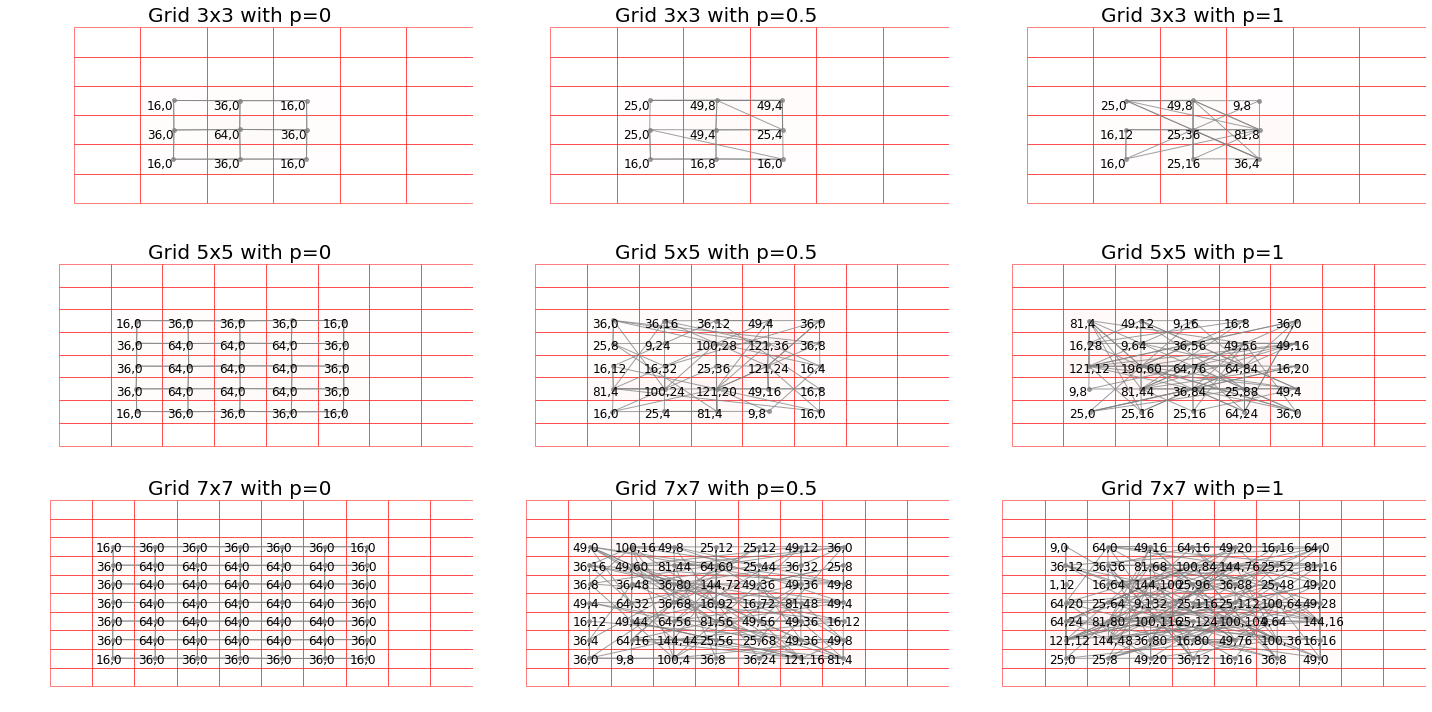

In [181]:
lattice_constant = 1
offset_ratio = 100
dimension = 2
grid_size_list = [3,5,7]
p_list = [0, 0.5, 1]  # Different probabilities for rewiring
box_side_length = 1
fig, axs = plt.subplots(len(grid_size_list), len(p_list), figsize=(20, 10))  # Adjust for two rows

for grid_idx, grid_size in enumerate(grid_size_list):
    for i, p in enumerate(p_list):
        G = nx.MultiGraph()
        G = create_grid_and_connect(G, grid_size, lattice_constant, offset_ratio, dimension)
        G = rewire_edges(G, p)

        pos = {node: G.nodes[node]['pos'][:2] for node in G.nodes()}  # Adjust pos to 2D for plotting
        #edge_colors = []  
        #for u, v in G.edges():
        #    edge_colors.append(edge_colors_dict.get((u, v), 'black'))
        if len(grid_size_list) > 1:
            ax = axs[grid_idx, i]
        else:
            ax = axs[i]

        # Correctly draw partitions with the box_colors_dict
        box_bounding_box_list, subgraph_info_dict,in_contribution_dict, cross_contribution_dict = draw_partitions(ax, box_side_length, -1, grid_size + 1)

        # Plot the graph
        nx.draw(G, pos, ax=ax, node_color='gray',edge_color='gray',alpha=0.75,node_size=15)
        ax.set_title(f'Grid {grid_size}x{grid_size} with p={p}')
        ax.set_xlim([-2, grid_size+2])
        ax.set_ylim([-2, grid_size+2])

plt.tight_layout()
plt.show()